In [1]:
import tensorflow as tf
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import covariance
from skimage.io import imread
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, Normalizer, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, accuracy_score, confusion_matrix


plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')


X_data_train = pd.read_csv("data/train.txt", header = None)
X_data_validation = pd.read_csv("data/validation.txt", header = None)
X_data_test = pd.read_csv("data/test.txt", header = None)

def get_images(path, data):
    data_images =[]
    for i in range(data.shape[0]):
        img = imread(path + data[0][i])
        img = np.asarray(img)
        data_images.append(img)
    return np.array(data_images)


X_train_vanilla = get_images("data/train/", X_data_train)
X_validation_vanilla = get_images("data/validation/", X_data_validation)
X_test_vanilla = get_images("data/test/", X_data_test)

X_train = X_train_vanilla.flatten().reshape(X_train_vanilla.shape[0], np.prod(X_train_vanilla.shape[1:]))
y_train = X_data_train[1]
X_valid = X_validation_vanilla.flatten().reshape(X_validation_vanilla.shape[0], np.prod(X_validation_vanilla.shape[1:]))
y_valid = X_data_validation[1]
X_test = X_test_vanilla.flatten().reshape(X_validation_vanilla.shape[0], np.prod(X_validation_vanilla.shape[1:]))

# scaler = Normalizer('max').fit(X_train)
# scaler.transform(X_train)
# scaler.transform(X_valid)
#X_train, X_valid, y_train, y_valid = train_test_split(X_flattened, y, train_size=0.7, random_state=0)
# i_size = (32,32)
# X_train
X_train_total = np.concatenate((X_train, X_valid))
y_train_total = np.concatenate((y_train, y_valid))

#X_train = X_train/255
#X_valid = X_valid/255

In [ ]:
plt.imshow(X_train[0].reshape((32,32)), cmap='gray')

Score:  0.503


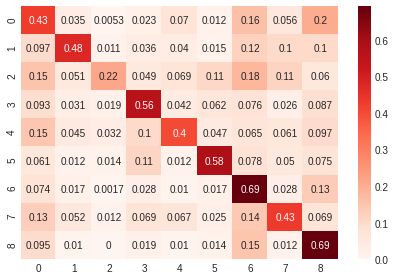

In [24]:
#preprocessor_KNN = RobustScaler()
preprocessor_KNN = MinMaxScaler()
#preprocessor_KNN = StandardScaler()
X_train_KNN = preprocessor_KNN.fit_transform(X_train)
X_valid_KNN = preprocessor_KNN.transform(X_valid)
X_test_KNN = preprocessor_KNN.transform(X_test)

# KNN model 0.4916
# knn_scores =[]
# for i in range(5,15):
#     KNN_model = KNeighborsClassifier(i)
#     KNN_model.fit(X_train_KNN, y_train)
#     score = KNN_model.score(X_valid_KNN, y_valid)
#     print (i, score)
#     knn_scores.append({"neighbors": i, 'score': score})

# We got best score on 9 neighbors

# Apparently the algorithm doesn't change anything so auto is better in this case(ball_tree takes years)
# KNN_model = KNeighborsClassifier(
#     n_neighbors=9,
#     algorithm='ball_tree',
#     n_jobs=-1
# )
# KNN_model.fit(X_train_KNN, y_train)
# score = KNN_model.score(X_valid_KNN, y_valid)
# print ('ball_tree', score)
#
# KNN_model = KNeighborsClassifier(
#     n_neighbors=9,
#     algorithm='kd_tree',
#     n_jobs=-1
# )
# KNN_model.fit(X_train_KNN, y_train)
# score = KNN_model.score(X_valid_KNN, y_valid)
# print ('kd_tree: ', score)
#
# KNN_model = KNeighborsClassifier(
#     n_neighbors=9,
#     algorithm='brute',
#     n_jobs=-1
# )
# KNN_model.fit(X_train_KNN, y_train)
# score = KNN_model.score(X_valid_KNN, y_valid)
# print ('Brute: ', score)
KNN_model = KNeighborsClassifier(
    n_neighbors=9,
    n_jobs=-1,
    p=1
)
KNN_model.fit(X_train_KNN, y_train)
# score = KNN_model.score(X_valid_KNN, y_valid)
predictions = KNN_model.predict(X_valid_KNN)
score = accuracy_score(y_valid, predictions)

confusion_matrix_KNN = confusion_matrix(
    y_valid,
    predictions,
    normalize='true'
)
plot_cm = sn.heatmap(confusion_matrix_KNN, annot=True, cmap=plt.cm.Reds)
plot_cm.get_figure().savefig('plot_cm_KNN')

print ('Score: ', score)

## Scores for KNN with no params:
- 1: 0.4416
- 2: 0.4316
- 3: 0.452
- 4: 0.475
- 5: 0.4772
- 6: 0.4824
- 7: 0.483
- 8: 0.4834
- 9: 0.4916
- 10: 0.4906
- 11: 0.4904
- 12: 0.4908
- 13: 0.485
- 14: 0.4844
- 15: 0.4854
- 16: 0.4868
- 17: 0.4828
- 18: 0.4826
- 19: 0.4858

- We got 0.503 with l1 (better than l2, 0.4916)
    ```
    KNN_model = KNeighborsClassifier(
        n_neighbors=9,
        n_jobs=-1,
        p=1
    )
    ```

### Best is neighbors of 9 , 0.4916

In [25]:
# Naive Bayes
def values_to_bins(data, bins):
    bins_data = np.digitize(data, bins)
    return bins_data - 1
bins_scores = []
naive_bayes_model = MultinomialNB(alpha=0.2)
# We've seen bins = 12 is the best for this case so we'll be working with 12 bins
# for num_bins in range(2,50,2):
#     bins = np.linspace(start=0, stop = 255, num=num_bins)
#     train = values_to_bins(X_train, bins)
#     valid = values_to_bins(X_valid, bins)
#     naive_bayes_model.fit(train, y_train)
#     score = naive_bayes_model.score(valid, y_valid)
#     print ('bins: ' + str(num_bins) + ':',  score)
#     bins_scores.append({"bins": num_bins, "score": score})
# for alpha in np.arange(0.1,1.0,0.1):
#     naive_bayes_model = MultinomialNB(alpha=alpha)
#     bins = np.linspace(start=0, stop = 255, num=12)
#     # apparently data is too big for alpha to matter? -> dividing by 12 looks the best
#     train = values_to_bins(X_train, bins)/12
#     valid = values_to_bins(X_valid, bins)/12
#     naive_bayes_model.fit(train, y_train)
#     score = naive_bayes_model.score(valid, y_valid)
#     print ('Alpha: ' + str(alpha) + ': ', score)

bins = np.linspace(start=0, stop = 255, num=12)
train = values_to_bins(X_train, bins)
valid = values_to_bins(X_valid, bins)

Multinomial:  0.392


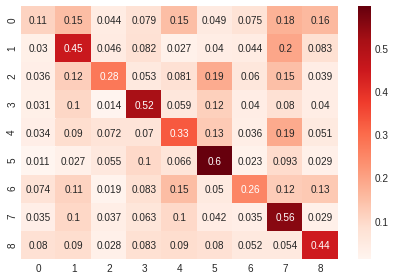

In [26]:
#score 3.774
naive_bayes_model = MultinomialNB(alpha=0.2)
naive_bayes_model.fit(train, y_train)
# score = naive_bayes_model.score(valid, y_valid)
predictions = naive_bayes_model.predict(valid)
score = accuracy_score(y_valid, predictions)

confusion_matrix_NB = confusion_matrix(
    y_valid,
    predictions,
    normalize='true'
)
plot_cm_NBM = sn.heatmap(confusion_matrix_NB, annot=True, cmap=plt.cm.Reds)
plot_cm_NBM.get_figure().savefig('plot_cm_NBM')

print ('Multinomial: ', score)

Bernoulli:  0.3214


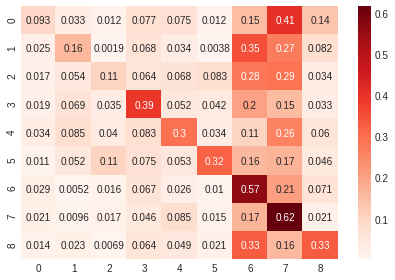

In [27]:
#score 3.774
bernoulli_naive_bayes = BernoulliNB(binarize=0.2)
bernoulli_naive_bayes.fit(train, y_train)
#score = bernoulli_naive_bayes.score(valid, y_valid)
#print ("Bernoulli: " , score)
predictions = bernoulli_naive_bayes.predict(valid)
score = accuracy_score(y_valid, predictions)

confusion_matrix_NBB = confusion_matrix(
    y_valid,
    predictions,
    normalize='true'
)
plot_cm_NBB = sn.heatmap(confusion_matrix_NBB, annot=True, cmap=plt.cm.Reds)
plot_cm_NBB.get_figure().savefig('plot_cm_NBB')

print ('Bernoulli: ', score)

Gaussian:  0.3996


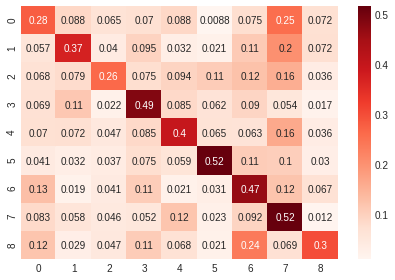

In [28]:
gaussian_naive_bayes = GaussianNB()
gaussian_naive_bayes.fit(train, y_train)
#score = gaussian_naive_bayes.score(valid, y_valid)
#print ("Gaussian: " , score)

predictions = gaussian_naive_bayes.predict(valid)
score = accuracy_score(y_valid, predictions)

confusion_matrix_NBG = confusion_matrix(
    y_valid,
    predictions,
    normalize='true'
)
plot_cm_NBG = sn.heatmap(confusion_matrix_NBG, annot=True, cmap=plt.cm.Reds)
plot_cm_NBG.get_figure().savefig('plot_cm_NBG')

print ('Gaussian: ', score)

# 0.3904
# 3: 0.3582
# 5: 0.3856
# 7: 0.3894
# 9: 0.391
# 10: 0.392
# 11: 0.3916
# 12 0.392 -- best with MultinomialNB -> 12 bins
# 13: 0.3906
# 15: 0.3894
# 17: 0.391
# 19: 0.3908
# 21: 0.3912
# 23: 0.3904
# 25: 0.3906
# Multinomial:  0.392
# Bernoulli:  0.3214
# Gaussian:  0.3996
# the best is gaussianNB one 0.3996

Score:  0.596


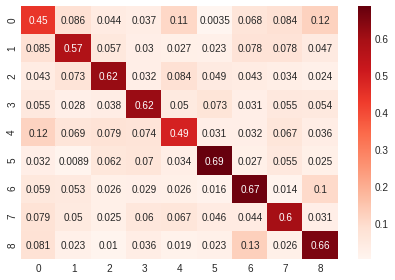

In [3]:
#preprocessor_LDA = RobustScaler()
preprocessor_LDA = MinMaxScaler()
#preprocessor_LDA = StandardScaler()
X_train_LDA = preprocessor_LDA.fit_transform(X_train)
X_valid_LDA = preprocessor_LDA.transform(X_valid)
X_test_LDA = preprocessor_LDA.transform(X_test)
# Linear Discriminant Analasys
linear_discriminant_model = LinearDiscriminantAnalysis(
    solver='lsqr',
    shrinkage='auto'
)
linear_discriminant_model.fit(X_train_LDA, y_train)
score = linear_discriminant_model.score(X_valid_LDA, y_valid)
# print (score)
predictions = linear_discriminant_model.predict(X_valid_LDA)
score = accuracy_score(y_valid, predictions)

confusion_matrix_LDA = confusion_matrix(
    y_valid,
    predictions,
    normalize='true'
)
plot_cm_LDA = sn.heatmap(confusion_matrix_LDA, annot=True, cmap=plt.cm.Reds)
plot_cm_LDA.get_figure().savefig('plot_cm_LDA_lsqr_a')

print ('Score: ', score)
# Default gets 0.588
# lsqr with shrinkage auto -> 0.596

Score:  0.605


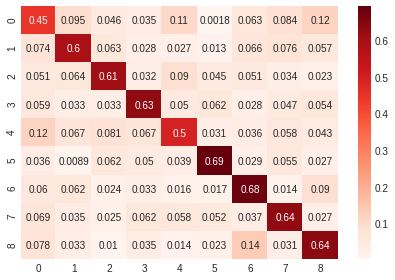

In [4]:
linear_discriminant_model = LinearDiscriminantAnalysis(
    solver='eigen',
    covariance_estimator=covariance.ShrunkCovariance()
)
linear_discriminant_model.fit(X_train_LDA, y_train)
score = linear_discriminant_model.score(X_valid_LDA, y_valid)
# print (score)
predictions = linear_discriminant_model.predict(X_valid_LDA)
score = accuracy_score(y_valid, predictions)

confusion_matrix_LDA = confusion_matrix(
    y_valid,
    predictions,
    normalize='true'
)
plot_cm_LDA = sn.heatmap(confusion_matrix_LDA, annot=True, cmap=plt.cm.Reds)
plot_cm_LDA.get_figure().savefig('plot_cm_LDA_eigen')

print ('Score: ', score)

Score:  0.605


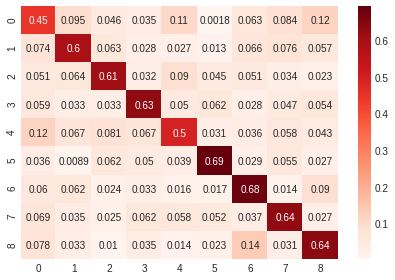

In [5]:
linear_discriminant_model = LinearDiscriminantAnalysis(
    solver='lsqr',
    covariance_estimator=covariance.ShrunkCovariance()
)
linear_discriminant_model.fit(X_train_LDA, y_train)
score = linear_discriminant_model.score(X_valid_LDA, y_valid)
# print (score)
predictions = linear_discriminant_model.predict(X_valid_LDA)
score = accuracy_score(y_valid, predictions)

confusion_matrix_LDA = confusion_matrix(
    y_valid,
    predictions,
    normalize='true'
)
plot_cm_LDA = sn.heatmap(confusion_matrix_LDA, annot=True, cmap=plt.cm.Reds)
plot_cm_LDA.get_figure().savefig('plot_cm_LDA_lsqr_cov')

print ('Score: ', score)

In [6]:
#preprocessor_final_LDA = RobustScaler()
preprocessor_final_LDA = MinMaxScaler()
#preprocessor_final_LDA = StandardScaler()
X_train_total_final_LDA = preprocessor_final_LDA.fit_transform(X_train_total)
X_test_final_LDA = preprocessor_final_LDA.transform(X_test)

best_linear_discriminant_model = LinearDiscriminantAnalysis(
    solver='lsqr',
    covariance_estimator=covariance.ShrunkCovariance()
)

best_linear_discriminant_model.fit(X_train_total_final_LDA, y_train_total)
test_answer = best_linear_discriminant_model.predict(X_test_final_LDA)
output = pd.DataFrame({'id': X_data_test[0],
                       'label': test_answer})
print(output.head())
output.to_csv('submission_LDA.cvs', index = False)

           id  label
0  035001.png      7
1  035002.png      4
2  035003.png      4
3  035004.png      7
4  035005.png      4


* linear_discriminant_model = LinearDiscriminantAnalysis()
    * 0.588
* linear_discriminant_model = LinearDiscriminantAnalysis(
    solver='lsqr',
    shrinkage='auto'
)
    - 0.596
* linear_discriminant_model = LinearDiscriminantAnalysis(
    solver='eigen',
    covariance_estimator=covariance.ShrunkCovariance()
)
    * 0.604
* linear_discriminant_model = LinearDiscriminantAnalysis(
    solver='lsqr',
    covariance_estimator=covariance.ShrunkCovariance()
)
    * 0.605


In [ ]:
# Image augmentation test
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
X_generator = X_train_vanilla.reshape(-1, 32, 32, 1)
datagen.fit(X_generator)
generator = datagen.flow(X_generator, y_train, batch_size=32)
X_data, y_data = generator.next()
for img in X_data:
    # print (type(img))
    # print (img.shape)
    plt.figure()
    plt.imshow(img, cmap='gray')

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
X_generator = X_train_vanilla.reshape(-1, 32, 32, 1)
datagen.fit(X_generator)
generator = datagen.flow(X_generator, y_train, batch_size=30001)
X_data, y_data = generator.next()
X_data = X_data.flatten().reshape(X_data.shape[0], np.prod(X_data.shape[1:]))
print (X_train.shape)
print (X_data.shape)
X_total_SVM = np.concatenate((X_train, X_data))
y_total_SVM = np.concatenate((y_train, y_data))
print (X_total_SVM.shape)
# Hmmm, it doesn't do that well with image augmentation

In [ ]:
#preprocessor_SVM = RobustScaler()
preprocessor_SVM = MinMaxScaler()
#preprocessor_SVM = StandardScaler()
X_train_SVM = preprocessor_SVM.fit_transform(X_train)
X_valid_SVM = preprocessor_SVM.transform(X_valid)
X_test_SVM = preprocessor_SVM.transform(X_test)



# Takes way tooooo long to load
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    X_train_SVM[:10000],
    y_train[:10000],
    train_size=0.8,
    random_state=0
)
SVC_model = SVC(
    C=1.0,
    kernel='rbf',
    cache_size=4000,
    tol=1e-5,
    decision_function_shape="ovr",
    class_weight='balanced',
    random_state=0
)

SVC_model.fit(X_train_split, y_train_split)
#score = SVC_model.score(X_valid_split, y_valid_split)
#print(score)

In [ ]:
predictions = SVC_model.predict(X_valid_split)
score = accuracy_score(y_valid_split, predictions)

confusion_matrix_SVC = confusion_matrix(
    y_valid_split,
    predictions,
    normalize='true'
)
plot_cm_SVC = sn.heatmap(confusion_matrix_SVC, annot=True, cmap=plt.cm.Reds)
plot_cm_SVC.get_figure().savefig('plot_cm_SVC_ovr_c')

print ('Score: ', score)

### Trainings done on 10k data so it's a reasonable wait time
* SVC_model = SVC(
    C=0.8,
    kernel='rbf',
    cache_size=4000,
    tol=1e-5,
    decision_function_shape="ovo",
    random_state=0
)
    * 0.648
* SVC_model = SVC(
    C=0.8,
    kernel='rbf',
    cache_size=4000,
    tol=1e-5,
    decision_function_shape="ovr",
    class_weight='balanced',
    random_state=0
)
    * 0.65
* SVC_model = SVC(
    C=1.0,
    kernel='rbf',
    cache_size=4000,
    tol=1e-5,
    decision_function_shape="ovr",
    class_weight='balanced',
    random_state=0
)
    * 0.6605
    * 0.73 on all data with a train split, and 0.75 on kaggle for train+valid train

In [ ]:
#Sender SVM
#preprocessor_final_SVM = RobustScaler()
preprocessor_final_SVM = MinMaxScaler()
#preprocessor_final_SVM = StandardScaler()
X_train_total_final_SVM = preprocessor_final_SVM.fit_transform(X_train_total)
X_test_final_SVM = preprocessor_final_SVM.transform(X_test)

best_SVC_model = SVC(
    C=1.0,
    kernel='rbf',
    cache_size=4000,
    shrinking=True,
    tol=1e-2,
    decision_function_shape="ovr",
    class_weight='balanced',
    random_state=0
)
best_SVC_model.fit(X_train_total_final_SVM, y_train_total)
test_answer = best_SVC_model.predict(X_test_final_SVM)
output = pd.DataFrame({'id': X_data_test[0],
                       'label': test_answer})
print(output.head())
output.to_csv('submission_SVC.cvs', index = False)



Epoch 1/33
63/63 [==============================] - 8s 123ms/step - loss: 1.8464 - accuracy: 0.3289 - val_loss: 1.1125 - val_accuracy: 0.6405

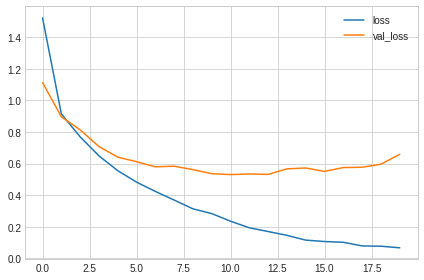

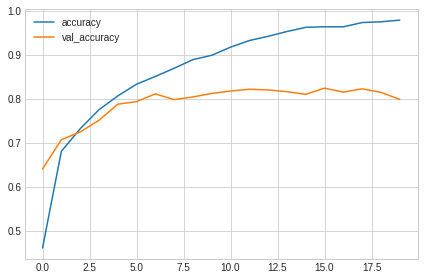

In [17]:
#preprocessor_CNN = RobustScaler()
preprocessor_CNN = MinMaxScaler()
#preprocessor_CNN = StandardScaler()
X_train_CNN = preprocessor_CNN.fit_transform(X_train).reshape((X_train.shape[0],32 ,32, 1))
X_valid_CNN = preprocessor_CNN.transform(X_valid).reshape((X_valid.shape[0], 32,32, 1))
X_test_CNN = preprocessor_CNN.transform(X_test)

y_train_CNN = keras.utils.to_categorical(y_train, 9)
y_valid_CNN = keras.utils.to_categorical(y_valid, 9)

X_test_CNN = X_valid_CNN[3000:]
y_test_CNN = y_valid_CNN[3000:]
X_train_CNN = X_train_CNN[:8000]
y_train_CNN = y_train_CNN[:8000]
X_valid_CNN = X_valid_CNN[:2000]
y_valid_CNN = y_valid_CNN[:2000]
#y_valid_CNN_normal = y_valid[:2000]

neural_model = keras.Sequential ([
    layers.Input(shape=(32,32,1)),
    layers.Conv2D(20, kernel_size=5, padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Dropout(0.2),
    layers.Conv2D(60, kernel_size=5, padding="same", activation="relu"),
    layers.Dropout(0.3),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Flatten(),
    layers.Dense(400, activation='relu'),
    #layers.Dense(84, activation='relu'),
    layers.Dense(9, activation="softmax")
])
early_stopping = callbacks.EarlyStopping(
    min_delta=0.01,
    patience=10,
    restore_best_weights=True
)
adam = keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    amsgrad=False,
    name="Adam"
)
neural_model.compile(
    optimizer = adam,
    loss = "categorical_crossentropy",
    metrics=['accuracy']
)
result = neural_model.fit(
    X_train_CNN,
    y_train_CNN,
    batch_size = 128,
    validation_data=(X_valid_CNN, y_valid_CNN),
    epochs = 100,
    #shuffle=True,
    #verbose=False,
    use_multiprocessing=True,
    callbacks=[early_stopping]
)
print ("Accuracy: " + str(np.array(result.history['accuracy']).max()))
print ("Val accuracy:" + str(np.array(result.history['val_accuracy']).max()))

print (X_valid_CNN.shape)
print (X_valid.shape)
X_test_CNN = preprocessor_CNN.transform(X_test).reshape((X_test.shape[0], 32, 32, 1))


trainer = neural_model.predict(X_test_CNN)


history_pd = pd.DataFrame(result.history)
history_pd.loc[0:, ['loss', 'val_loss']].plot()
history_pd.loc[0:, ['accuracy', 'val_accuracy']].plot()
#history_pd.loc[50:, ['loss']].plot()
print (np.argmax(trainer , axis = 1))
#print (np.argmax(y_test_CNN, axis = 1))

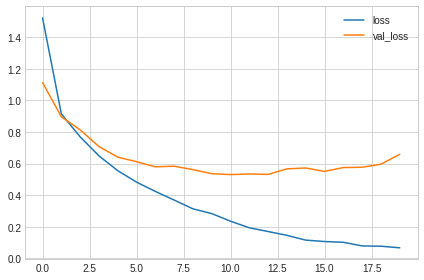

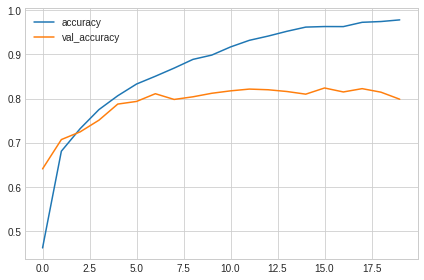

In [18]:
history_pd = pd.DataFrame(result.history)
plot_1 = history_pd.loc[0:, ['loss', 'val_loss']].plot()
plot_1.figure.savefig('plot_cm_CNN_1_1')
plot_2 = history_pd.loc[0:, ['accuracy', 'val_accuracy']].plot()
plot_2.figure.savefig('plot_cm_CNN_1_2')


In [ ]:
#preprocessor_CNN = RobustScaler()
preprocessor_CNN = MinMaxScaler()
#preprocessor_CNN = StandardScaler()
X_train_CNN = preprocessor_CNN.fit_transform(X_train).reshape((X_train.shape[0],32 ,32, 1))
X_valid_CNN = preprocessor_CNN.transform(X_valid).reshape((X_valid.shape[0], 32,32, 1))
X_test_CNN = preprocessor_CNN.transform(X_test)

y_train_CNN = keras.utils.to_categorical(y_train, 9)
y_valid_CNN = keras.utils.to_categorical(y_valid, 9)

X_test_CNN = X_valid_CNN[3000:]
y_test_CNN = y_valid_CNN[3000:]
X_train_CNN = X_train_CNN[:4000]
y_train_CNN = y_train_CNN[:4000]
X_valid_CNN = X_valid_CNN[:1000]
y_valid_CNN = y_valid_CNN[:1000]
#y_valid_CNN_normal = y_valid[:2000]

# this method didn't seem that good
# X_data, y_data = generator.next()
# No need to do any modification to X but we need to y
# X_data = X_data.flatten().reshape(X_data.shape[0], np.prod(X_data.shape[1:]))
# y_data = keras.utils.to_categorical(y_data, 9)
# X_train_CNN = np.concatenate((X_train_CNN, X_data))
# y_train_CNN = np.concatenate((y_train_CNN, y_data))
# started from leNet-5
# neural_model = keras.Sequential ([
#     layers.Input(shape=(32,32,1)),
#     layers.Conv2D(20, kernel_size=5, padding="same", activation="relu"),
#     layers.MaxPooling2D(pool_size=2, strides=2),
#     # layers.Dropout(0.2),
#     layers.BatchNormalization(),
#
#     layers.Conv2D(20, kernel_size=5, padding="same"),
#     layers.Dropout(0.3),
#     layers.Activation('relu'),
#
#     layers.Conv2D(60, kernel_size=5, padding="same"),
#     layers.Dropout(0.3),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=2, strides=2),
#     layers.Flatten(),
#     layers.Dense(400, activation='relu'),
#     # layers.Dropout(0.2),
#     # layers.Dense(84, activation='relu'),
#     layers.Dense(9, activation="softmax")
# ])
# based on VGG16
# neural_model = keras.Sequential ([
#     layers.Input(shape=(32,32,1)),
#     layers.Conv2D(16, kernel_size=5, padding="same", activation="relu"),
#     layers.Conv2D(16, kernel_size=5, padding="same", activation="relu"),
#     layers.MaxPooling2D(pool_size=2, strides=2),
#     layers.Dropout(0.3),
#     layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
#     layers.Dropout(0.3),
#     layers.MaxPooling2D(pool_size=2, strides=2),
#     layers.Flatten(),
#     layers.Dense(256, activation='relu'),
#     #layers.Dense(84, activation='relu'),
#     layers.Dense(9, activation="softmax")
# ])
# neural_model = keras.Sequential ([
#     layers.Input(shape=(32,32,1)),
#     layers.Conv2D(36, kernel_size=5, padding="valid", activation="relu"),
#     layers.Conv2D(72, kernel_size=3,padding='same', strides=2, activation="relu"),
#     layers.Dropout(0.2),
#     layers.AveragePooling2D(pool_size=2, strides=2),
#     layers.Conv2D(144, kernel_size=3, padding="same", activation="relu"),
#     layers.AveragePooling2D(pool_size=2, strides=2),
#     layers.Dropout(0.3),
#     layers.Conv2D(72, kernel_size=3, padding="same", activation="relu"),
#     layers.Dropout(0.2),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(9, activation="softmax")
# ])
neural_model = keras.Sequential ([
    layers.Input(shape=(32,32,1)),
    layers.Conv2D(32, kernel_size=3, activation="relu"),
    layers.Conv2D(32, kernel_size=3, activation="relu"),
    layers.Conv2D(32, kernel_size=5, padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Dropout(0.2),
    layers.Conv2D(64, kernel_size=3, activation="relu"),
    layers.Conv2D(64, kernel_size=3, activation="relu"),
    layers.Conv2D(128, kernel_size=5, padding="same", activation="relu"),
    layers.Dropout(0.3),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Flatten(),
    layers.Dense(1000, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(9, activation="softmax")
])


early_stopping = callbacks.EarlyStopping(
    min_delta=0.01,
    patience=10,
    restore_best_weights=True
)

RMSprop = keras.optimizers.RMSprop(
    learning_rate=0.0001,
    rho=0.9,
    momentum=0.0,
    decay=0.0,
    epsilon=1e-07,
    centered=True,
    name="RMSprop"
)

adam = keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    amsgrad=True,
    name="Adam"
)
adagrad = keras.optimizers.Adagrad(
    learning_rate=0.04,
    initial_accumulator_value=0.8,
    epsilon=1e-07,
    name="Adagrad"
)
SGD = keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.1,
    nesterov=False,
    name="SGD"
)

neural_model.compile(
    optimizer = adam,
    loss = "categorical_crossentropy",
    metrics=['accuracy']
)
neural_model.summary()

In [28]:
# training
result = neural_model.fit(
    X_train_CNN,
    y_train_CNN,
    batch_size = 128,
    validation_data=(X_valid_CNN, y_valid_CNN),
    epochs = 100,
    #shuffle=True,
    #verbose=False,
    use_multiprocessing=True,
    callbacks=[early_stopping]
)
print ("Accuracy: " + str(np.array(result.history['accuracy']).mean()))
print ("Val accuracy:" + str(np.array(result.history['val_accuracy']).mean()))

Epoch 1/100
 3/32 [=>............................] - ETA: 36s - loss: 3.9063 - accuracy: 0.1185 

KeyboardInterrupt: 

In [53]:
#training on generator (image augmentation)
#Def. doing something wrong here, it doesn't work
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)
X_generator = X_train
X_generator = preprocessor_CNN.transform(X_generator)
X_generator = X_generator.reshape(-1, 32, 32, 1)
y_generator = y_train
y_generator = keras.utils.to_categorical(y_generator, 9)
datagen.fit(X_generator)
generator = datagen.flow(X_generator, y_generator, batch_size=128)
result = neural_model.fit(
    generator,
    steps_per_epoch = X_generator.shape[0] // 128,
    validation_data=(X_valid_CNN, y_valid_CNN),
    epochs = 100,
    #shuffle=True,
    #verbose=False,
    #use_multiprocessing=True,
    callbacks=[early_stopping]
)
print ("Accuracy: " + str(np.array(result.history['accuracy']).mean()))
print ("Val accuracy:" + str(np.array(result.history['val_accuracy']).mean()))

Epoch 1/100
234/234 [==============================] - 130s 551ms/step - loss: 1.8542 - accuracy: 0.3059 - val_loss: 0.9912 - val_accuracy: 0.7160

(1000, 32, 32, 1)
(5000, 1024)
[5 0 6 ... 7 0 4]


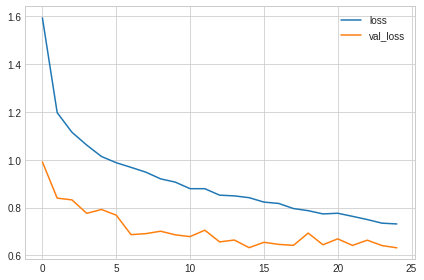

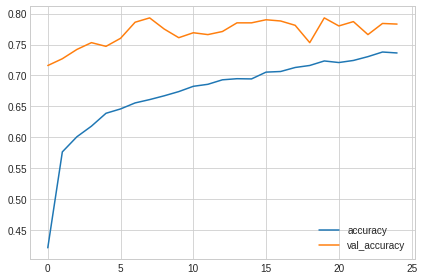

In [55]:
# tester
print (X_valid_CNN.shape)
print (X_valid.shape)
X_test_CNN = preprocessor_CNN.transform(X_test).reshape((X_test.shape[0], 32, 32, 1))


trainer = neural_model.predict(X_test_CNN)


history_pd = pd.DataFrame(result.history)
history_pd.loc[0:, ['loss', 'val_loss']].plot()
history_pd.loc[0:, ['accuracy', 'val_accuracy']].plot()
#history_pd.loc[50:, ['loss']].plot()
print (np.argmax(trainer , axis = 1))
#print (np.argmax(y_test_CNN, axis = 1))


In [54]:
# sender
X_test_CNN = preprocessor_CNN.transform(X_test).reshape((X_test.shape[0], 32, 32, 1))
trainer = neural_model.predict(X_test_CNN)

trainer = np.argmax(trainer, axis = 1)
print (trainer)
#print (np.argmax(trainer , axis = 1))
#print (np.argmax(y_test_CNN, axis = 1))

output = pd.DataFrame({'id': X_data_test[0],
                       'label': trainer})
print(output.head())
output.to_csv('submission_CNN_7.cvs', index = False)

[5 0 6 ... 7 0 4]
           id  label
0  035001.png      5
1  035002.png      0
2  035003.png      6
3  035004.png      5
4  035005.png      5


* ```
neural_model = keras.Sequential ([
    layers.Input(shape=(32,32,1)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(9, activation="softmax")
])
adam = keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    amsgrad=False,
    name="Adam"
)
neural_model.compile(
    optimizer = adam,
    loss = "categorical_crossentropy",
    metrics=['accuracy']
)
result = neural_model.fit(
    X_train_CNN,
    y_train_CNN,
    batch_size = 2048,
    validation_data=(X_valid_CNN, y_valid_CNN),
    epochs = 33,
    #shuffle=True,
    #verbose=False,
    use_multiprocessing=True,
    callbacks=[early_stopping]
)
print ("Accuracy: " + str(np.array(result.history['accuracy']).mean()))
print ("Val accuracy:" + str(np.array(result.history['val_accuracy']).mean()))
  ```
  * 0.78-0.79
* ```
neural_model = keras.Sequential ([
    layers.Input(shape=(32,32,1)),
    layers.Conv2D(20, kernel_size=5, padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Dropout(0.2),
    layers.Conv2D(60, kernel_size=5, padding="same", activation="relu"),
    layers.Dropout(0.3),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Flatten(),
    layers.Dense(400, activation='relu'),
    #layers.Dense(84, activation='relu'),
    layers.Dense(9, activation="softmax")
])
early_stopping = callbacks.EarlyStopping(
    min_delta=0.01,
    patience=5,
    restore_best_weights=True
)
adam = keras.optimizers.Adam(
    learning_rate=0.0005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    amsgrad=True,
    name="Adam"
)
neural_model.compile(
    optimizer = adam,
    loss = "categorical_crossentropy",
    metrics=['accuracy']
)
neural_model.summary()
```
    * 0.89%
    * It's a LeNet-5 arhitecture based. If I can normalize better I might get ~92%
    * On small data:
        * Adagrad tops at 0.82, seems to overtrain up to 0.96
        * adam at 0.82,  seems to overtrain till 0.95
        * RMSprop at 0.81 and overtrains till 0.92 -- looks like all algs need more normalization

Trainer with no image augmentation ^
```
Epoch 1/100
235/235 [==============================] - 28s 118ms/step - loss: 1.4926 - accuracy: 0.4666 - val_loss: 0.8225 - val_accuracy: 0.7402
Epoch 2/100
235/235 [==============================] - 32s 136ms/step - loss: 0.7456 - accuracy: 0.7409 - val_loss: 0.7001 - val_accuracy: 0.7730
Epoch 3/100
235/235 [==============================] - 31s 133ms/step - loss: 0.6007 - accuracy: 0.7919 - val_loss: 0.5645 - val_accuracy: 0.8216
Epoch 4/100
235/235 [==============================] - 32s 135ms/step - loss: 0.5018 - accuracy: 0.8268 - val_loss: 0.5435 - val_accuracy: 0.8200
Epoch 5/100
235/235 [==============================] - 32s 138ms/step - loss: 0.4460 - accuracy: 0.8412 - val_loss: 0.4763 - val_accuracy: 0.8406
Epoch 6/100
235/235 [==============================] - 33s 139ms/step - loss: 0.3921 - accuracy: 0.8655 - val_loss: 0.4335 - val_accuracy: 0.8570
Epoch 7/100
235/235 [==============================] - 34s 143ms/step - loss: 0.3442 - accuracy: 0.8763 - val_loss: 0.4137 - val_accuracy: 0.8650
Epoch 8/100
235/235 [==============================] - 34s 145ms/step - loss: 0.3150 - accuracy: 0.8869 - val_loss: 0.4054 - val_accuracy: 0.8562
Epoch 9/100
235/235 [==============================] - 35s 148ms/step - loss: 0.2697 - accuracy: 0.9045 - val_loss: 0.4103 - val_accuracy: 0.8562
Epoch 10/100
235/235 [==============================] - 36s 153ms/step - loss: 0.2483 - accuracy: 0.9110 - val_loss: 0.3555 - val_accuracy: 0.8762
Epoch 11/100
235/235 [==============================] - 36s 155ms/step - loss: 0.2163 - accuracy: 0.9228 - val_loss: 0.3440 - val_accuracy: 0.8776
Epoch 12/100
235/235 [==============================] - 35s 149ms/step - loss: 0.1894 - accuracy: 0.9350 - val_loss: 0.3465 - val_accuracy: 0.8744
Epoch 13/100
235/235 [==============================] - 35s 151ms/step - loss: 0.1751 - accuracy: 0.9369 - val_loss: 0.3393 - val_accuracy: 0.8748
Epoch 14/100
235/235 [==============================] - 35s 150ms/step - loss: 0.1505 - accuracy: 0.9486 - val_loss: 0.3432 - val_accuracy: 0.8810
Epoch 15/100
235/235 [==============================] - 40s 169ms/step - loss: 0.1274 - accuracy: 0.9552 - val_loss: 0.3346 - val_accuracy: 0.8868
Epoch 16/100
235/235 [==============================] - 37s 158ms/step - loss: 0.1209 - accuracy: 0.9578 - val_loss: 0.3180 - val_accuracy: 0.8890
Epoch 17/100
235/235 [==============================] - 37s 157ms/step - loss: 0.1061 - accuracy: 0.9632 - val_loss: 0.3391 - val_accuracy: 0.8834
Epoch 18/100
235/235 [==============================] - 36s 155ms/step - loss: 0.0909 - accuracy: 0.9703 - val_loss: 0.3397 - val_accuracy: 0.8796
Epoch 19/100
235/235 [==============================] - 39s 166ms/step - loss: 0.0849 - accuracy: 0.9714 - val_loss: 0.3638 - val_accuracy: 0.8788
Epoch 20/100
235/235 [==============================] - 40s 171ms/step - loss: 0.0744 - accuracy: 0.9755 - val_loss: 0.3418 - val_accuracy: 0.8862
Epoch 21/100
235/235 [==============================] - 36s 151ms/step - loss: 0.0715 - accuracy: 0.9770 - val_loss: 0.3397 - val_accuracy: 0.8872
Accuracy: 0.8928861107145037
Val accuracy:0.8573714296023051
```
With image augmentation it gets the same vals on small dataset, trying big:

* ```
neural_model = keras.Sequential ([
    layers.Input(shape=(32,32,1)),
    layers.Conv2D(30, kernel_size=5, padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Dropout(0.2),
    layers.Conv2D(60, kernel_size=5, padding="same", activation="relu"),
    layers.Dropout(0.3),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Flatten(),
    layers.Dense(200, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(84, activation='relu'),
    layers.Dense(9, activation="softmax")
])
```
Sadge
```
Epoch 1/100
235/235 [==============================] - 38s 159ms/step - loss: 1.6719 - accuracy: 0.3911 - val_loss: 0.8756 - val_accuracy: 0.7304
Epoch 2/100
235/235 [==============================] - 45s 193ms/step - loss: 0.8494 - accuracy: 0.7045 - val_loss: 0.6883 - val_accuracy: 0.7810
Epoch 3/100
235/235 [==============================] - 45s 192ms/step - loss: 0.7004 - accuracy: 0.7570 - val_loss: 0.5867 - val_accuracy: 0.8094
Epoch 4/100
235/235 [==============================] - 53s 225ms/step - loss: 0.6152 - accuracy: 0.7855 - val_loss: 0.5733 - val_accuracy: 0.8142
Epoch 5/100
235/235 [==============================] - 55s 236ms/step - loss: 0.5579 - accuracy: 0.8028 - val_loss: 0.5000 - val_accuracy: 0.8390
Epoch 6/100
235/235 [==============================] - 57s 243ms/step - loss: 0.5030 - accuracy: 0.8239 - val_loss: 0.4621 - val_accuracy: 0.8440
Epoch 7/100
235/235 [==============================] - 58s 248ms/step - loss: 0.4569 - accuracy: 0.8382 - val_loss: 0.4628 - val_accuracy: 0.8462
Epoch 8/100
235/235 [==============================] - 56s 239ms/step - loss: 0.4110 - accuracy: 0.8550 - val_loss: 0.4107 - val_accuracy: 0.8640
Epoch 9/100
235/235 [==============================] - 56s 238ms/step - loss: 0.3920 - accuracy: 0.8624 - val_loss: 0.4058 - val_accuracy: 0.8610
Epoch 10/100
235/235 [==============================] - 55s 233ms/step - loss: 0.3687 - accuracy: 0.8712 - val_loss: 0.3896 - val_accuracy: 0.8696
Epoch 11/100
235/235 [==============================] - 57s 243ms/step - loss: 0.3333 - accuracy: 0.8837 - val_loss: 0.3810 - val_accuracy: 0.8744
Epoch 12/100
235/235 [==============================] - 56s 238ms/step - loss: 0.3215 - accuracy: 0.8838 - val_loss: 0.3638 - val_accuracy: 0.8780
Epoch 13/100
235/235 [==============================] - 56s 238ms/step - loss: 0.3010 - accuracy: 0.8933 - val_loss: 0.3584 - val_accuracy: 0.8774
Epoch 14/100
235/235 [==============================] - 53s 226ms/step - loss: 0.2763 - accuracy: 0.8995 - val_loss: 0.3577 - val_accuracy: 0.8776
Epoch 15/100
235/235 [==============================] - 64s 272ms/step - loss: 0.2649 - accuracy: 0.9066 - val_loss: 0.3492 - val_accuracy: 0.8808
Epoch 16/100
235/235 [==============================] - 51s 218ms/step - loss: 0.2586 - accuracy: 0.9061 - val_loss: 0.3418 - val_accuracy: 0.8822
Epoch 17/100
235/235 [==============================] - 66s 283ms/step - loss: 0.2406 - accuracy: 0.9152 - val_loss: 0.3421 - val_accuracy: 0.8836
Epoch 18/100
235/235 [==============================] - 60s 257ms/step - loss: 0.2241 - accuracy: 0.9204 - val_loss: 0.3295 - val_accuracy: 0.8850
Epoch 19/100
235/235 [==============================] - 58s 247ms/step - loss: 0.2132 - accuracy: 0.9219 - val_loss: 0.3374 - val_accuracy: 0.8828
Epoch 20/100
235/235 [==============================] - 61s 261ms/step - loss: 0.2067 - accuracy: 0.9251 - val_loss: 0.3336 - val_accuracy: 0.8860
Epoch 21/100
235/235 [==============================] - 63s 270ms/step - loss: 0.1939 - accuracy: 0.9275 - val_loss: 0.3331 - val_accuracy: 0.8850
Epoch 22/100
235/235 [==============================] - 63s 267ms/step - loss: 0.1854 - accuracy: 0.9334 - val_loss: 0.3409 - val_accuracy: 0.8836
Epoch 23/100
235/235 [==============================] - 77s 327ms/step - loss: 0.1800 - accuracy: 0.9338 - val_loss: 0.3282 - val_accuracy: 0.8862
Epoch 24/100
235/235 [==============================] - 71s 303ms/step - loss: 0.1750 - accuracy: 0.9363 - val_loss: 0.3241 - val_accuracy: 0.8862
Epoch 25/100
235/235 [==============================] - 61s 262ms/step - loss: 0.1666 - accuracy: 0.9387 - val_loss: 0.3378 - val_accuracy: 0.8830
Epoch 26/100
235/235 [==============================] - 68s 289ms/step - loss: 0.1566 - accuracy: 0.9447 - val_loss: 0.3340 - val_accuracy: 0.8852
Epoch 27/100
235/235 [==============================] - 61s 260ms/step - loss: 0.1550 - accuracy: 0.9452 - val_loss: 0.3462 - val_accuracy: 0.8848
Epoch 28/100
235/235 [==============================] - 59s 252ms/step - loss: 0.1505 - accuracy: 0.9442 - val_loss: 0.3395 - val_accuracy: 0.8826
Epoch 29/100
235/235 [==============================] - 64s 273ms/step - loss: 0.1375 - accuracy: 0.9518 - val_loss: 0.3578 - val_accuracy: 0.8784
Epoch 30/100
235/235 [==============================] - 63s 268ms/step - loss: 0.1459 - accuracy: 0.9494 - val_loss: 0.3349 - val_accuracy: 0.8856
Epoch 31/100
235/235 [==============================] - 65s 275ms/step - loss: 0.1338 - accuracy: 0.9526 - val_loss: 0.3375 - val_accuracy: 0.8850
Epoch 32/100
235/235 [==============================] - 65s 275ms/step - loss: 0.1253 - accuracy: 0.9568 - val_loss: 0.3426 - val_accuracy: 0.8836
Epoch 33/100
235/235 [==============================] - 64s 274ms/step - loss: 0.1242 - accuracy: 0.9551 - val_loss: 0.3515 - val_accuracy: 0.8842
Epoch 34/100
235/235 [==============================] - 64s 274ms/step - loss: 0.1234 - accuracy: 0.9556 - val_loss: 0.3504 - val_accuracy: 0.8872
Accuracy: 0.8851146137013155
Val accuracy:0.8660941194085514
```

sender 5
```
neural_model = keras.Sequential ([
    layers.Input(shape=(32,32,1)),
    layers.Conv2D(25, kernel_size=5, padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Dropout(0.2),
    layers.Conv2D(85, kernel_size=5, padding="same", activation="relu"),
    layers.Dropout(0.3),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Flatten(),
    layers.Dense(220, activation='relu'), # + 20 -- revert back, + is usually better
    layers.Dropout(0.3),
    layers.Dense(100, activation='relu'), # - 10 -- - is much better
    layers.Dense(9, activation="softmax")
])
```


